# MNIST Digit Completion: ricostruzione di cifre osservandone metà

Questo notebook presenta una soluzione al task di *MNIST digit completion*, finalizzato alla ricostruzione di immagini di cifre scritte a mano a partire da una porzione osservata dell’immagine, tramite l’impiego di reti neurali.


## Impostazione del problema e approccio

Il task di digit completion può essere formulato come un problema di ricostruzione condizionata, in cui l’obiettivo è dedurre la parte mancante di un’immagine a partire dalla regione osservata.

Data un’immagine parzialmente osservata $X_{\text{masked}}$, l’obiettivo è ricostruire l’immagine originale $X$.  
In alcuni casi, informazioni aggiuntive come l’etichetta della cifra $Y$ possono essere sfruttate per guidare il processo di ricostruzione.

Da un punto di vista probabilistico, questo corrisponde a modellare la distribuzione condizionata

$$
P(X \mid X_{\text{masked}}) \quad \text{oppure} \quad P(X \mid X_{\text{masked}}, Y).
$$
-------------------------------------------------


## Dipendenze e librerie utilizzate


In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Reshape, Embedding, Concatenate,
    Conv2D, Conv2DTranspose, UpSampling2D,
    BatchNormalization, LeakyReLU
)
from tensorflow.keras.optimizers import Adam

-------------

## Modello di baseline e motivazione
Prima di concentrarsi sul task di digit completion, viene introdotto un modello di classificazione supervisionata come baseline di riferimento.

Tale modello apprende la distribuzione condizionata $P(Y \mid X)$ e viene utilizzato per richiamare i concetti fondamentali dell’apprendimento supervisionato trattati nel corso, oltre a fornire un riferimento concettuale per motivare l’utilizzo dell’informazione di classe nei modelli generativi condizionati.


In [82]:
# Caricamento e preprocessamento dei dati
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],28,28,1))
x_test = x_test.reshape((x_test.shape[0],28,28,1))

# Generatore di batch
def generator(data,label,batchsize):
  x = np.zeros((batchsize,28,28,1))
  while True:
    batch_id = np.random.randint(0,data.shape[0],batchsize)
    x[:,:,:14] = data[batch_id,:,:14]
    yield (x,label[batch_id]),data[batch_id]
# Calcolo della media per ogni cifra
mean_digit = np.zeros((10,28,28,1))
for i in range(10):
  mean_digit[i] = np.mean(x_train[y_train==i],axis=0)
# Normalizzazione della media
mean_digit = mean_digit - mean_digit.min()
mean_digit = mean_digit/mean_digit.max()

# Funzione di baseline
def baseline(x,l):
  res = np.copy(x)
  res[:,:,14:28] = mean_digit[l,:,14:28]
  return res

---

## Metrica di valutazione
Useremo come metrica di valutazione mean squared error, ma al fine di meglio evidenziare il risultato consideriamo il rapporto con la baseline.

In [83]:
# Funzione di valutazione (Restituisce il rapporto MSE modello / MSE baseline)
def evaluation(pred,l,y):
  res_baseline = baseline(y,l) #baseline for y or the input x is the same
  mse_baseline = np.mean((y-res_baseline)**2)
  mse = np.mean((y-pred)**2)
  print("MSE:", mse)
  return mse/mse_baseline

### Visualizzazione dei risultati
Per valutare qualitativamente le prestazioni del modello, vengono visualizzati, per ciascun esempio:
- l’immagine di input parzialmente osservata,
- l’immagine ricostruita dal modello,
- la ground truth, corrispondente all’immagine originale non mascherata.


In [84]:
def plot_sample(x,label,y, t):
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(x[:,:,0],cmap='gray')
  ax[0].set_title(f'Label {label}')
  ax[1].imshow(y[:,:,0],cmap='gray')
  ax[1].set_title('Output')
  ax[2].imshow(t[:,:,0],cmap='gray')
  ax[2].set_title('Ground truth')
  plt.show()

### Test baseline
L’output generato dalla baseline risulta limitato, in quanto non sfrutta l’informazione visiva dell’immagine osservata. Questo motiva l’introduzione di un modello più espressivo per il task di digit completion.

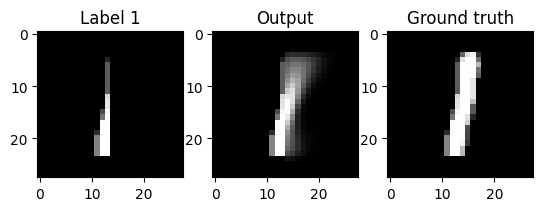

In [85]:
#generatore di un batch di dimensione 1 per l'esempio
one_generator = generator(x_train,y_train,1)

(x,l),y = next(one_generator)
plot_sample(x[0],l[0],baseline(x,l)[0], y[0])

---

## Modello proposto

In questa sezione viene presentata la soluzione proposta per il task di digit completion, basata su un autoencoder convoluzionale condizionato sull’etichetta della cifra.


### Input del modello
Il modello riceve in input un’immagine MNIST parzialmente osservata e l’etichetta della cifra corrispondente.  
L’immagine mascherata rappresenta l’informazione visiva disponibile, mentre l’etichetta viene utilizzata come informazione di condizionamento.


In [86]:
input_img = Input(shape=(28, 28, 1), name='image_input')
label_input = Input(shape=(), dtype='int32', name='label_input')

### Embedding dell’etichetta
L’etichetta della cifra viene trasformata in una rappresentazione continua tramite un embedding, che viene poi adattato a una struttura spaziale compatibile con la rappresentazione latente dell’encoder.


In [87]:
label_emb = Embedding(10, 16)(label_input)
label_emb = Dense(7 * 7, activation='relu')(label_emb)
label_emb = Reshape((7, 7, 1))(label_emb)

### Encoder

L’encoder ha il compito di estrarre una rappresentazione compatta dell’immagine parzialmente osservata, riducendo progressivamente la risoluzione spaziale e aumentando il numero di feature.


In [88]:
x = Conv2D(32, 3, strides=2, padding='same')(input_img)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

### Bottleneck e integrazione del condizionamento
La rappresentazione prodotta dall’encoder viene combinata con l’informazione di classe nel bottleneck del modello.

In questa fase, la rappresentazione latente dell’immagine parzialmente osservata viene arricchita con l’embedding dell’etichetta, permettendo al decoder di ricostruire l’immagine tenendo conto sia dell’informazione visiva disponibile sia della classe della cifra.


In [89]:
x = Concatenate(axis=-1)([x, label_emb])

### Decoder
Il decoder ha il compito di ricostruire l’immagine originale a partire dalla rappresentazione latente condizionata prodotta dal bottleneck.

A partire da tale rappresentazione compatta, il decoder ripristina progressivamente la risoluzione spaziale dell’immagine tramite operazioni di upsampling e convoluzione, producendo come output una ricostruzione dell’immagine di input.

In [90]:
x = Conv2DTranspose(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

output_img = Conv2DTranspose(
    1, 3, activation='sigmoid', padding='same'
)(x)

### Modello completo e funzione di loss
Le diverse componenti del modello vengono ora integrate in un’unica architettura end-to-end.

Il modello riceve in input l’immagine parzialmente osservata e l’etichetta della cifra, e produce come output l’immagine ricostruita.  
L’addestramento viene effettuato minimizzando una funzione di loss di ricostruzione, misurata come errore quadratico medio (MSE) tra l’output del modello e la ground truth.

In [91]:
autoencoder = Model(
    inputs=[input_img, label_input],
    outputs=output_img
)
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse'
)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ leaky_re_lu_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ leaky_re_lu_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 16)        │        160 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 49)        │        833 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 7, 7, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 7, 7, 129) │          0 │ leaky_re_lu_14[0… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 7, 7, 128) │    148,736 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                 

 Total params: 336,738 (1.28 MB)

 Trainable params: 335,842 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)

### Costruzione del dataset e mascheramento delle immagini
Per addestrare il modello sul task di digit completion, è necessario costruire una pipeline dati che produca coppie (input, target).

In particolare:
- l’input del modello è l’immagine mascherata $X_{\text{masked}}$ (ed eventualmente l’etichetta $Y$ come condizionamento),
- il target (ground truth) è l’immagine originale $X$.

Il mascheramento viene applicato all’interno del generatore, in modo da ottenere dinamicamente gli input a partire dalle immagini MNIST originali.

In [92]:
def make_dataset(x_data, y_data, batchsize):
    # Funzione per mascherare la metà destra(colonne da 14 a 27) dell'immagine
    def mask_image(x):
        mask = tf.concat(
            [
                tf.ones_like(x[:, :, :14, :]),
                tf.zeros_like(x[:, :, 14:, :])
            ],
            axis=2
        )
        return x * mask

    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.shuffle(1024).batch(batchsize)
    dataset = dataset.map(
        lambda x, y: (
            {'image_input': mask_image(x), 'label_input': y},
            x
        )
    )
    # Tramite .repeat() il dataset diventa infinito. La durata di un'epoca
    # sarà determinata da steps_per_epoch
    dataset = dataset.repeat()
    # Questa scelta consente di definire in modo diretto il numero di 
    # aggiornamenti effettuati per epoca durante l’addestramento.
    return dataset

train_ds = make_dataset(x_train, y_train, 32)
val_ds   = make_dataset(x_test, y_test, 32)

### Addestramento del modello
Il modello viene addestrato utilizzando il dataset costruito in precedenza, che fornisce in input immagini mascherate e come target le immagini originali.

L’addestramento viene eseguito per un numero fissato di epoche, mentre un dataset di validazione separato viene utilizzato per monitorare l’andamento della loss durante il training.

In [93]:
history = autoencoder.fit(
    train_ds,
    steps_per_epoch=200,
    epochs=12,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 341ms/step - loss: 0.0390 - val_loss: 0.0796
Epoch 2/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 315ms/step - loss: 0.0219 - val_loss: 0.0439
Epoch 3/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 58s 288ms/step - loss: 0.0205 - val_loss: 0.0212
Epoch 4/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - loss: 0.0198 - val_loss: 0.0199
Epoch 5/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - loss: 0.0191 - val_loss: 0.0193
Epoch 6/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 413ms/step - loss: 0.0186 - val_loss: 0.0189
Epoch 7/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 8/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - loss: 0.0184 - val_loss: 0.0179
Epoch 9/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - loss: 0.0175 - val_loss: 0.0180
Epoch 10/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 11/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - loss: 0.0172 - val_loss: 0.0176
Epoch 12/12
200/200

### Traccia dell’addestramento
Di seguito viene riportato l’andamento della funzione di loss sul training set e sul validation set durante le epoche di addestramento.

L’andamento della loss mostra la convergenza del modello durante l’addestramento.  
Il confronto tra training e validation loss permette di monitorare eventuali fenomeni di overfitting.

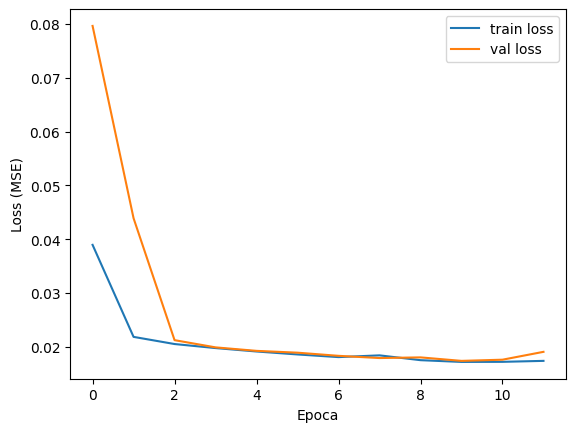

In [94]:
# Plot della loss di addestramento e validazione
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoca")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

### Risultati qualitativi
Di seguito vengono mostrati alcuni esempi di ricostruzione sul test set, confrontando:
- l’input mascherato $X_{\text{masked}}$,
- l’output del modello,
- la ground truth (immagine originale).

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


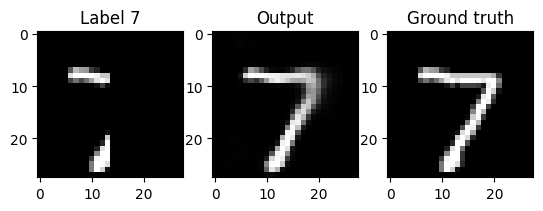

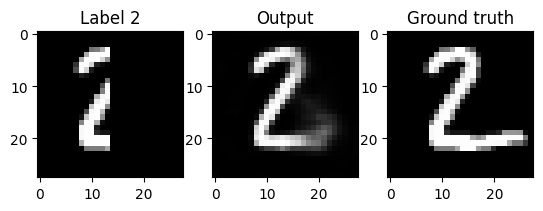

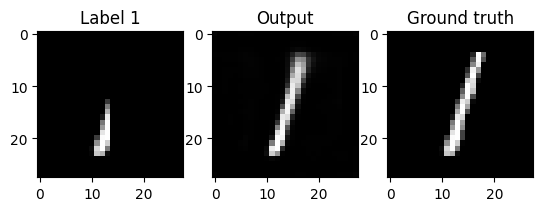

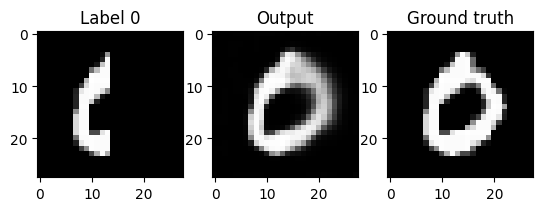

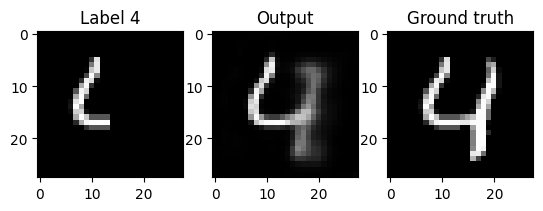

In [95]:
#grandezza della batch
batch_size = 5

# Funzione numpy per mascherare le immagini
def mask_numpy(x):
    x = x.copy()
    x[:, :, 14:, :] = 0.0
    return x

x_gt = x_test[:batch_size]          # ground truth
y_lbl = y_test[:batch_size]
x_masked = mask_numpy(x_gt)         # input mascherato

pred = autoencoder.predict([x_masked, y_lbl])

for i in range(batch_size):
    plot_sample(x_masked[i], y_lbl[i], pred[i], x_gt[i])


### Valutazione finale
La qualità delle ricostruzioni viene valutata utilizzando la funzione `evaluation` fornita nella traccia.  
Il punteggio viene confrontato con la baseline di riferimento.

In [96]:
x_test_masked = mask_numpy(x_test)
pred_test = autoencoder.predict([x_test_masked, y_test], batch_size=32)
score_model = evaluation(pred_test, y_test, x_test)

print("Final score (model):", score_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step
MSE: 0.018928029
Final score (model): 0.6606366


---

## Salvataggio e caricamento dei pesi (gdown)

Per rendere riproducibile l’esecuzione senza dover rieseguire il training, i pesi del modello vengono salvati e resi scaricabili tramite Google Drive usando `gdown`.


In [104]:
%pip install -q gdown
import gdown

autoencoder.save_weights("autoencoder.weights.h5")
print("Pesi salvati in autoencoder.weights.h5")

file_id = "1wNYFX5fZzIMjAnL4Aa6wdtYZ5nAwPCxD"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "autoencoder.weights.h5", quiet=False)
autoencoder.load_weights("autoencoder.weights.h5")
print("Pesi caricati correttamente.")


Note: you may need to restart the kernel to use updated packages.
Pesi salvati in autoencoder.weights.h5


Downloading...
From: https://drive.google.com/uc?id=1wNYFX5fZzIMjAnL4Aa6wdtYZ5nAwPCxD
To: /home/vincenzo/Documenti/uni/ML/MnistCompletition/MnistHalfCompletition/autoencoder.weights.h5
100%|██████████| 4.13M/4.13M [00:01<00:00, 3.37MB/s]


Pesi caricati correttamente.


## Limiti del modello e considerazioni sulla generalizzazione
Il modello proposto è adattato specificatamente al task di digit completion su MNIST, dove la struttura delle cifre è relativamente semplice e la variabilità limitata.  
In contesti più complessi, ad esempio immagini naturali o mascheramenti non deterministici, un approccio puramente basato su MSE potrebbe favorire soluzioni eccessivamente conservative, penalizzando la plausibilità percettiva delle ricostruzioni.

In tali scenari, sarebbe necessario adottare modelli e metriche differenti, in grado di catturare meglio la distribuzione delle possibili soluzioni, come modelli generativi probabilistici o criteri di valutazione percettivi, ma utilizzarli sarebbe stato contro le linee stesse del progetto, che esplicita l'utilizzo di MSE.

## Altri modelli provati
È stata sperimentata una variante del modello che utilizzava una funzione di loss pesata (`weighted MSE`) durante la fase di training, con l’obiettivo di dare maggiore importanza ad alcune componenti della ricostruzione.  
Tale approccio ha portato a risultati qualitativi visivamente più precisi, ma non ha mostrato miglioramenti significativi in fase di valutazione, effettuata utilizzando la metrica MSE standard. Inoltre, questa scelta ha evidenziato una maggiore tendenza all’overfitting, motivo per cui è stata scartata.

È stato inoltre valutato un aumento della complessità dell’autoencoder tramite l’aggiunta di un ulteriore livello nel decoder. Questa modifica ha comportato un aumento significativo dei tempi di addestramento, senza un corrispondente miglioramento delle prestazioni finali.

È stata inoltre considerata l’adozione di un approccio esplicitamente generativo, ad esempio tramite una formulazione variazionale (VAE), che avrebbe consentito di modellare una distribuzione delle possibili ricostruzioni della parte mancante dell’immagine.  
Tale approccio non è stato approfondito in quanto la metrica di valutazione fornita, basata su MSE deterministico, non risulta adatta a valutare modelli stocastici, e avrebbe penalizzato soluzioni basate sul campionamento.

---


## Discussione dei risultati
Il modello proposto supera la baseline secondo la metrica `evaluation`, indicando che la ricostruzione beneficia dell’informazione visiva disponibile e del condizionamento sull’etichetta.  
Gli esempi qualitativi mostrano che la forma della cifra viene ricostruita in modo più coerente rispetto al riferimento minimo.